In [1]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [3]:
cd '/content/gdrive/My Drive/Real_time_HW3'

/content/gdrive/My Drive/Real_time_HW3


In [4]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn

In [5]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn


In [8]:
pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install --upgrade d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:

pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [12]:
import torchvision.transforms as transforms

In [13]:
data_dir = './data' 
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(),transforms.Resize(64)])
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:

print(len(trainset))
sample = next(iter(trainset))
print(len(sample))
image, label = sample
print(type(image))
print(type(label))
image.shape
print(len(testset))

50000
2
<class 'torch.Tensor'>
<class 'int'>
10000


horse


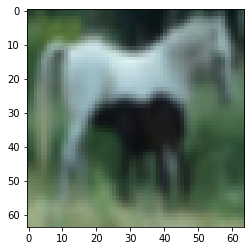

horse


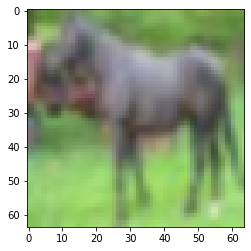

frog


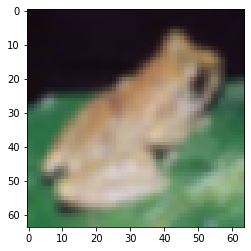

truck


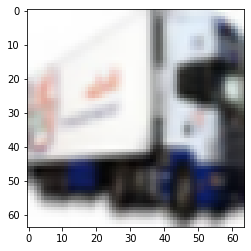

plane


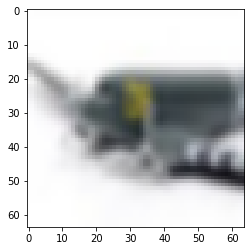

cat


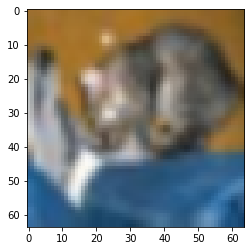

ship


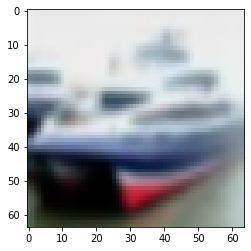

ship


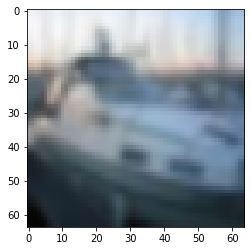

plane


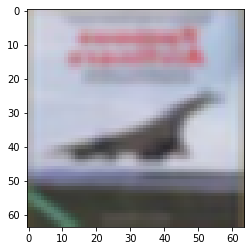

frog


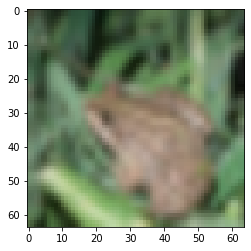

In [15]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
batch = next(dataiter)
labels = batch[1][0:5]
images = batch[0][0:5]
for i in range(5):
    print(classes[labels[i]])
    image = images[i].numpy()
    plt.imshow(np.rot90(image.T, k=3))
    plt.show()

dataiter = iter(test_loader)
batch = next(dataiter)
labels = batch[1][0:5]
images = batch[0][0:5]
for i in range(5):
    print(classes[labels[i]])
    image = images[i].numpy()
    plt.imshow(np.rot90(image.T, k=3))
    plt.show()

In [16]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [17]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

In [18]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [19]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [20]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [21]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [27]:
class ResNet34(ResNet):
    def __init__(self, lr=0.01, num_classes=10):
        super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)),
                       lr, num_classes)


ResNet34()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet34(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentu

In [28]:
model = ResNet34(lr=0.01)

In [29]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [30]:
import torch.optim as optim

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [32]:
device = 'cuda' 
model.to(device)

ResNet34(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentu

1,  2000| loss: 2.353
1,  4000| loss: 2.054
1,  6000| loss: 1.881
1,  8000| loss: 1.756
1, 10000| loss: 1.671
2,  2000| loss: 1.595
2,  4000| loss: 1.536
2,  6000| loss: 1.483
2,  8000| loss: 1.414
2, 10000| loss: 1.361
3,  2000| loss: 1.313
3,  4000| loss: 1.252
3,  6000| loss: 1.212
3,  8000| loss: 1.189
3, 10000| loss: 1.161
4,  2000| loss: 1.066
4,  4000| loss: 1.058
4,  6000| loss: 1.042
4,  8000| loss: 1.046
4, 10000| loss: 1.000
5,  2000| loss: 0.949
5,  4000| loss: 0.928
5,  6000| loss: 0.910
5,  8000| loss: 0.891
5, 10000| loss: 0.875
6,  2000| loss: 0.832
6,  4000| loss: 0.824
6,  6000| loss: 0.779
6,  8000| loss: 0.794
6, 10000| loss: 0.795
7,  2000| loss: 0.749
7,  4000| loss: 0.719
7,  6000| loss: 0.721
7,  8000| loss: 0.721
7, 10000| loss: 0.709
8,  2000| loss: 0.663
8,  4000| loss: 0.654
8,  6000| loss: 0.650
8,  8000| loss: 0.664
8, 10000| loss: 0.640
9,  2000| loss: 0.592
9,  4000| loss: 0.601
9,  6000| loss: 0.618
9,  8000| loss: 0.595
9, 10000| loss: 0.602
10,  2000|

Text(0.5, 1.0, 'Convergence of Loss')

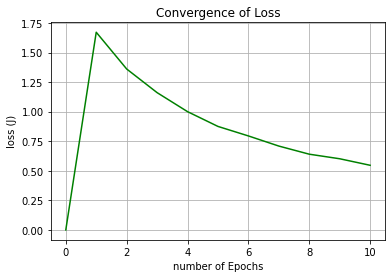

In [33]:
epoch_losses = [] 
model.train()
n_epochs=10
train_losses = np.zeros(n_epochs+1)

for epoch in range(n_epochs):
    
    running_loss = 0.0
    saved_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
       

        loss.backward()
        optimizer.step()
       
       
        running_loss += loss.item()
        train_losses[epoch+1]=running_loss/2000
        if i % 2000 == 1999:  
            print('%d, %5d| loss: %.3f' %(epoch+1, i+1, running_loss/2000))
            saved_loss = running_loss
            running_loss = 0.0

    epoch_losses.append(saved_loss/10000)
    
plt.plot(train_losses, color = 'green')
plt.rcParams["figure.figsize"] = (10, 6)
plt.grid()
plt.xlabel('number of Epochs')
plt.ylabel('loss (J)')
plt.title('Convergence of Loss') 
   

In [34]:
total = 0
correct = 0
model.eval() 
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Model Accuracy: %d %%' % (100 * correct / total))

Model Accuracy: 78 %


In [35]:
pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=5218512328f234c965b9a610108e6939b4db3c6874dc2457e5eca1fc66c8d26c
  Stored in directory: /root/.cache/pip/wheels/86/07/9f/879035d99d7b639bbc564d23fed862a679aee7d1a2dced8c2e
Successfully built ptflops


In [36]:
sum([param.nelement() for param in model.parameters()])

21296522

In [37]:
pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sovrasov/flops-counter.pytorch.git to /tmp/pip-req-build-k84t6mct
  Running command git clone --filter=blob:none --quiet https://github.com/sovrasov/flops-counter.pytorch.git /tmp/pip-req-build-k84t6mct
  Resolved https://github.com/sovrasov/flops-counter.pytorch.git to commit 64a8dbdfb8cd85d1d7bb1d3f7237b8eafec78005
  Preparing metadata (setup.py) ... done


In [38]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = model
  macs, params = get_model_complexity_info(net, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet34(
  21.3 M, 100.000% Params, 300.07 MMac, 100.000% MACs, 
  (net): Sequential(
    21.3 M, 100.000% Params, 300.07 MMac, 100.000% MACs, 
    (0): Sequential(
      9.6 k, 0.045% Params, 9.96 MMac, 3.320% MACs, 
      (0): Conv2d(9.47 k, 0.044% Params, 9.7 MMac, 3.232% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.044% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.022% MACs, )
      (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.022% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      222.34 k, 1.044% Params, 56.92 MMac, 18.969% MACs, 
      (0): Residual(
        74.11 k, 0.348% Params, 18.97 MMac, 6.323% MACs, 
        (conv1): Conv2d(36.93 k, 0.173% Params, 9.45 MMac, 3.150% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(36.93 k, 0.1